# Counting gates in benchmark circuits

**Description**

Estimates the number of two-qubit gates and single-qubit gates for different randomized benchmarking circuits and for different mirror circuits. Both types of circuits are generated for different values of the abstract depth parameter $d$. The aim of this notebook is to estimate a relationship between $d$ and the actual number of physical gates.

## Setup

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import os
import functools
import time
from typing import Dict, List, Tuple, Union

# Plotting imports.
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams.update({"font.family": "serif", "font.size": 12})

# Third-party imports.
import cirq
import networkx as nx
import numpy as np
import pandas as pd

# Qiskit imports.
import qiskit
import qiskit.ignis.verification.randomized_benchmarking as rb
from qiskit.transpiler.passes import RemoveBarriers, RemoveFinalMeasurements
from qiskit.circuit import Gate

# Mitiq imports.
from mitiq.interface import convert_to_mitiq, convert_from_mitiq
from mitiq import benchmarks, pec, zne

# For hardware device offerings.
from braket.aws import AwsDevice
from braket.devices import LocalSimulator
from braket.circuits import Circuit, gates, Noise

/home/andrea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.


<IPython.core.display.Javascript object>

### Parameters

In [3]:
# Benchmark circuit type. Supported types are "rb" and "mirror".
circuit_type: str = "rb"  

# Qubits to use on the experiment. 
num_qubits = 3

qubits = [j for j in range(num_qubits)]

# Split qubits into 2-qubit pairs (assuming a chain connectivity). 
rb_pattern = [[qa, qb] for qa, qb in zip(qubits[0:-1:2], qubits[1::2])]
if len(qubits) % 2 == 1:
    # For an odd number of qubits, append final individual qubit to the RB pattern.
    rb_pattern.append([qubits[-1]])
print("Qubit indeces:", qubits)
print("RB pattern:", rb_pattern)


Qubit indeces: [0, 1, 2]
RB pattern: [[0, 1], [2]]


<IPython.core.display.Javascript object>

### Hardware parameters

In [4]:
# Hardware backend device type. Supported types are "rigetti", "ibmq", and "ionq".
hardware_type: str = "ibmq"

<IPython.core.display.Javascript object>

### Hardware architecture

If the user selects the option to run on an actual hardware offering, define the architectural layout of the quantum device. Otherwise, invoke the appropriate simulator.

In [5]:
computer = nx.Graph()

# Assume chain-like connectivity
computer.add_edges_from([(qa, qb) for qa, qb in zip(qubits[:-1], qubits[1:])])

# Add reversed edges to computer graph.
# This is important to represent CNOT gates with target and control reversed.
computer = nx.to_directed(computer)


# Check if RB-pattern is consistent with device topology.
for edge in rb_pattern:
    if len(edge) == 2:
        if edge not in computer.edges:
            raise ValueError(
                "The option rb_pattern is not consistent with the device topology."
            )

print("Computer connectivity (used only for mirror circuits):", computer.edges)

Computer connectivity (used only for mirror circuits): [(0, 1), (1, 0), (1, 2), (2, 1)]


<IPython.core.display.Javascript object>

### Benchmark circuit

In [6]:
def named_qubit_to_line_qubit(named_qubit: str) -> cirq.LineQubit:
    """Extract qubit number assuming "_" is used as a word separator."""
    digits = [int(s) for s in named_qubit.name.split("_") if s.isdigit()]
    if len(digits) == 1:
        return cirq.LineQubit(digits[0])
    else:
        raise RuntimeError("Failed to identify qubit number.")

<IPython.core.display.Javascript object>

In [7]:
def get_rb_circuit(
    depth: int, seed: int
) -> Union[Tuple[cirq.Circuit, str], Tuple[qiskit.QuantumCircuit, str]]:
    circuit = rb.randomized_benchmarking_seq(
        length_vector=[depth],
        rb_pattern=rb_pattern,
        group_gates="0",
        rand_seed=seed,
    )[0][0][0]

    # Remove barriers and measurements.
    circuit = RemoveFinalMeasurements()(RemoveBarriers()(circuit))

    if hardware_type == "ionq" or hardware_type == "rigetti":
        # Qiskit --> Cirq.
        cirq_circuit, _ = convert_to_mitiq(circuit)
        circuit_with_linequbits = cirq_circuit.transform_qubits(
            named_qubit_to_line_qubit
        )

        # Cirq --> Braket.
        return convert_from_mitiq(circuit_with_linequbits, "braket"), "0" * len(qubits)

    elif hardware_type == "ibmq":
        # Hack: Remove classical register and rename qubit register.
        return convert_from_mitiq(convert_to_mitiq(circuit)[0], "qiskit"), "0" * len(
            qubits
        )


def get_mirror_circuit(
    depth: int, seed: int
) -> Union[Tuple[cirq.Circuit, str], Tuple[qiskit.QuantumCircuit, str]]:

    return_type = (
        "braket" if hardware_type == "ionq" or hardware_type == "rigetti" else "qiskit"
    )
    circuit, correct_bitstring = benchmarks.generate_mirror_circuit(
        nlayers=depth,
        two_qubit_gate_prob=1.0,
        connectivity_graph=computer,
        two_qubit_gate_name="CNOT",
        seed=seed,
        return_type=return_type,
    )

    if hardware_type == "ionq" or hardware_type == "rigetti":
        return circuit, correct_bitstring
    elif hardware_type == "ibmq":
        # Reversed because Qiskit is wrong endian.
        return circuit, "".join(map(str, correct_bitstring[::-1]))

<IPython.core.display.Javascript object>

### Gateset compilation functions

In [8]:
def compile_to_rigetti_gateset(circuit: Circuit) -> Circuit:
    """Compiles AWS gates to Rigetti gateset. Taken from:
    https://mitiq.readthedocs.io/en/stable/examples/braket_mirror_circuit.html"""
    compiled = Circuit()

    for instr in circuit.instructions:
        if isinstance(instr.operator, gates.Vi):
            compiled.add_instruction(
                gates.Instruction(gates.Rx(-np.pi / 2), instr.target)
            )
        elif isinstance(instr.operator, gates.V):
            compiled.add_instruction(
                gates.Instruction(gates.Rx(np.pi / 2), instr.target)
            )
        elif isinstance(instr.operator, gates.Ry):
            compiled.add_instruction(
                gates.Instruction(gates.Rx(-np.pi / 2), instr.target)
            )
            compiled.add_instruction(
                gates.Instruction(gates.Rz(-instr.operator.angle), instr.target)
            )
            compiled.add_instruction(
                gates.Instruction(gates.Rx(np.pi / 2), instr.target)
            )
        elif isinstance(instr.operator, gates.Y):
            compiled.add_instruction(
                gates.Instruction(gates.Rx(-np.pi / 2), instr.target)
            )
            compiled.add_instruction(gates.Instruction(gates.Rz(np.pi), instr.target))
            compiled.add_instruction(
                gates.Instruction(gates.Rx(np.pi / 2), instr.target)
            )
        elif isinstance(instr.operator, gates.X):
            compiled.add_instruction(gates.Instruction(gates.Rx(np.pi), instr.target))
        elif isinstance(instr.operator, gates.Z):
            compiled.add_instruction(gates.Instruction(gates.Rz(np.pi), instr.target))
        elif isinstance(instr.operator, gates.S):
            compiled.add_instruction(
                gates.Instruction(gates.Rz(np.pi / 2), instr.target)
            )
        elif isinstance(instr.operator, gates.Si):
            compiled.add_instruction(
                gates.Instruction(gates.Rz(-np.pi / 2), instr.target)
            )
        elif isinstance(instr.operator, gates.H):
            compiled.add_instruction(
                gates.Instruction(gates.Rz(np.pi / 2), instr.target)
            )
            compiled.add_instruction(
                gates.Instruction(gates.Rx(np.pi / 2), instr.target)
            )
            compiled.add_instruction(
                gates.Instruction(gates.Rz(np.pi / 2), instr.target)
            )
        elif isinstance(instr.operator, gates.CNot):
            # First Hadamard
            compiled.add_instruction(
                gates.Instruction(gates.Rz(np.pi / 2), instr.target[1])
            )
            compiled.add_instruction(
                gates.Instruction(gates.Rx(np.pi / 2), instr.target[1])
            )
            compiled.add_instruction(
                gates.Instruction(gates.Rz(np.pi / 2), instr.target[1])
            )

            # Controlled-Z
            compiled.add_instruction(gates.Instruction(gates.CZ(), instr.target))

            # Second Hadamard
            compiled.add_instruction(
                gates.Instruction(gates.Rz(np.pi / 2), instr.target[1])
            )
            compiled.add_instruction(
                gates.Instruction(gates.Rx(np.pi / 2), instr.target[1])
            )
            compiled.add_instruction(
                gates.Instruction(gates.Rz(np.pi / 2), instr.target[1])
            )
        else:
            compiled.add_instruction(instr)

    return compiled

<IPython.core.display.Javascript object>

### CNOT count utility functions

In [9]:
def get_num_twoq_count(circuit: Union[cirq.Circuit, qiskit.QuantumCircuit]) -> int:
    """Determine number of two-qubit gates in a given `Circuit` object."""

    # Count CNOT gates for `cirq`-type circuit objects:
    if hardware_type == "ionq" or hardware_type == "rigetti":
        num_cnots: int = 0
        for instruction in circuit.instructions:
            if isinstance(instruction.operator, gates.CNot) or isinstance(
                instruction.operator, gates.CZ
            ):
                num_cnots += 1
        return num_cnots

    # Count CNOT gates for `qiskit`-type circuit objects:
    elif hardware_type == "ibmq":
        return circuit.count_ops().get("cx")


def get_oneq_count(circuit: Union[cirq.Circuit, qiskit.QuantumCircuit]) -> int:
    if hardware_type == "ionq" or hardware_type == "rigetti":
        return len(circuit.instructions) - get_num_twoq_count(circuit)
    elif hardware_type == "ibmq":
        return len(circuit) - get_num_twoq_count(circuit)

<IPython.core.display.Javascript object>

## Analyze the number of gates in RB circuits and in mirror circuits

In [10]:
def count_gates(circuit_type_to_analyze: str, num_trials=100, seed=0):
    """Analyze the number of two-qubit and single-qubit gates."""

    depths = [1, 3, 5, 7, 9, 12]

    num_twoq_gates = np.zeros(len(depths))
    num_oneq_gates = np.zeros(len(depths))
    for trial in range(num_trials):  # Average over different seeds
        num_twoq_gates_trial = []
        num_oneq_gates_trial = []

        for depth in depths:
            if circuit_type_to_analyze == "rb":
                circuit, _ = get_rb_circuit(
                    depth=depth, seed=seed + (10**3) * depth + (10**6) * trial
                )
            elif circuit_type_to_analyze == "mirror":
                circuit, _ = get_mirror_circuit(
                    depth=depth, seed=seed + (10**3) * depth + (10**6) * trial
                )

            # Compile to native gate set
            if hardware_type == "rigetti":
                circuit = compile_to_rigetti_gateset(circuit)

            num_twoq_gates_trial.append(get_num_twoq_count(circuit))
            num_oneq_gates_trial.append(get_oneq_count(circuit))
        num_twoq_gates += np.array(num_twoq_gates_trial)
        num_oneq_gates += np.array(num_oneq_gates_trial)

    num_twoq_gates /= num_trials
    num_oneq_gates /= num_trials

    twoq_params = np.polyfit(depths, num_twoq_gates, 1)
    twoq_curve = np.poly1d(twoq_params)

    oneq_params = np.polyfit(depths, num_oneq_gates, 1)
    oneq_curve = np.poly1d(oneq_params)

    print("depth\tnum. twoq\tnum oneq")
    print("-----------------------------------")

    for d, twoq, oneq in zip(depths, num_twoq_gates, num_oneq_gates):
        print(f"{d}\t{twoq}\t\t{oneq}")

    plt.ylabel("Number of two-qubit gates")
    plt.xlabel("d")
    plt.plot(
        depths,
        num_twoq_gates,
        "*",
        label=f"Two-qubit gates in {circuit_type_to_analyze} circuits",
    )
    plt.plot(
        depths,
        twoq_curve(depths),
        label=f"best fit: y={twoq_params[0]:.3} x + {twoq_params[1]:.3}",
    )
    plt.legend()
    plt.show()

    plt.ylabel("Number of one-qubit gates")
    plt.xlabel("d")
    plt.plot(
        depths,
        num_oneq_gates,
        "*",
        label=f"One-qubit gates in {circuit_type_to_analyze} circuits",
    )
    plt.plot(
        depths,
        oneq_curve(depths),
        label=f"best fit: y={oneq_params[0]:.3} x + {oneq_params[1]:.3}",
    )
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>

depth	num. twoq	num oneq
-----------------------------------
1	3.2		22.4
3	6.2		44.5
5	8.7		64.3
7	11.6		79.9
9	15.2		107.9
12	18.5		134.7


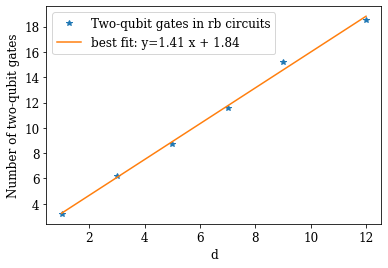

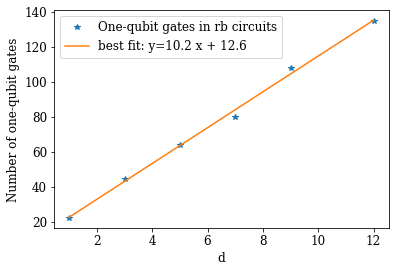

<IPython.core.display.Javascript object>

In [11]:
count_gates("rb", num_trials=10, seed=0)

depth	num. twoq	num oneq
-----------------------------------
1	2.0		26.2
3	6.0		45.6
5	10.0		67.6
7	14.0		87.2
9	18.0		108.4
12	24.0		138.4


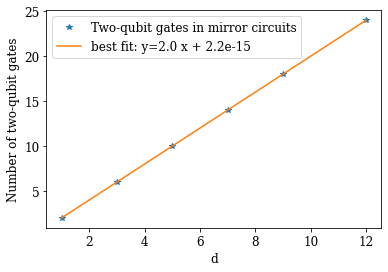

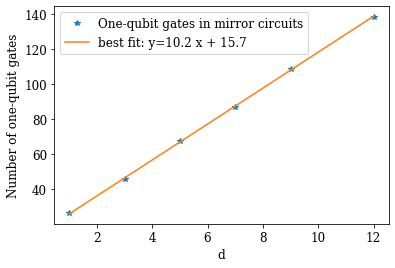

<IPython.core.display.Javascript object>

In [12]:
count_gates("mirror", num_trials=10, seed=0)